In [41]:
# ============================================
# ENVIRONMENT SETUP  
# ============================================
import sys
import os

# Detect environment
is_container = os.path.expanduser('~') == '/root'
print(f"Environment: {'Container/Colab' if is_container else 'Local'}")

if is_container:
    # Running in container - clone/update from GitHub
    if os.path.exists('/content/cure'):
        print("Updating to latest from GitHub...")
        os.chdir('/content/cure')
        !git fetch origin
        !git reset --hard origin/main
    else:
        print("Cloning repo...")
        !git clone https://github.com/RobbyPratl/cure.git /content/cure
        os.chdir('/content/cure')
    
    src_path = '/content/cure/src'
else:
    # Local development
    src_path = os.path.abspath('../src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)
print(f"src path: {src_path}")

Environment: Container/Colab
Updating to latest from GitHub...
HEAD is now at 3a00b30 Fix posterior sampling: use spatial domain sampling
src path: /content/cure/src


In [42]:
# Import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np

from degradations import (
    create_gaussian_kernel, degrade_image, 
    get_kernel_frequency_response
)
from utils import load_image, show_images, compute_psnr
from wiener import WienerFilter

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cpu
CUDA available: False


## 1. Create Test Image

We create a synthetic test image with various frequency content to analyze degradation effects.

Image shape: torch.Size([3, 256, 256])


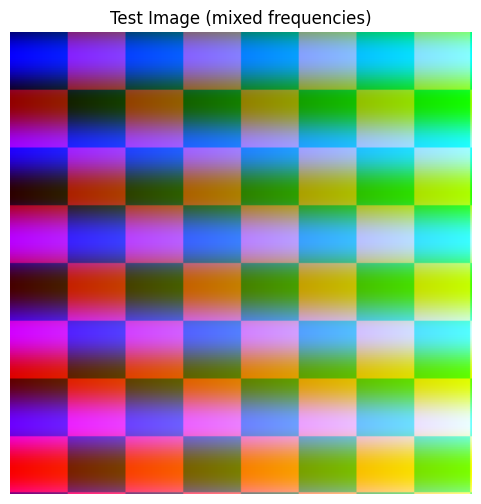

In [43]:
# Create test image with varying frequency content
def make_test_image(size=256):
    x = torch.linspace(0, 1, size)
    xx, yy = torch.meshgrid(x, x, indexing='ij')
    # Checkerboard pattern (high frequency)
    r = ((xx*8).long() + (yy*8).long()) % 2 * 0.5 + xx * 0.5
    # Gradient (low frequency)
    g = yy
    # Sinusoidal (medium frequency)
    b = torch.sin(xx * 10 * np.pi) * 0.5 + 0.5
    return torch.stack([r, g, b])

clean = make_test_image(256)
print(f"Image shape: {clean.shape}")

plt.figure(figsize=(6, 6))
plt.imshow(clean.permute(1, 2, 0))
plt.title('Test Image (mixed frequencies)')
plt.axis('off')
plt.show()

## 2. Apply Degradation

Apply Gaussian blur and additive noise to simulate a degraded observation.

Blur kernel shape: torch.Size([19, 19])
Noise sigma: 0.05


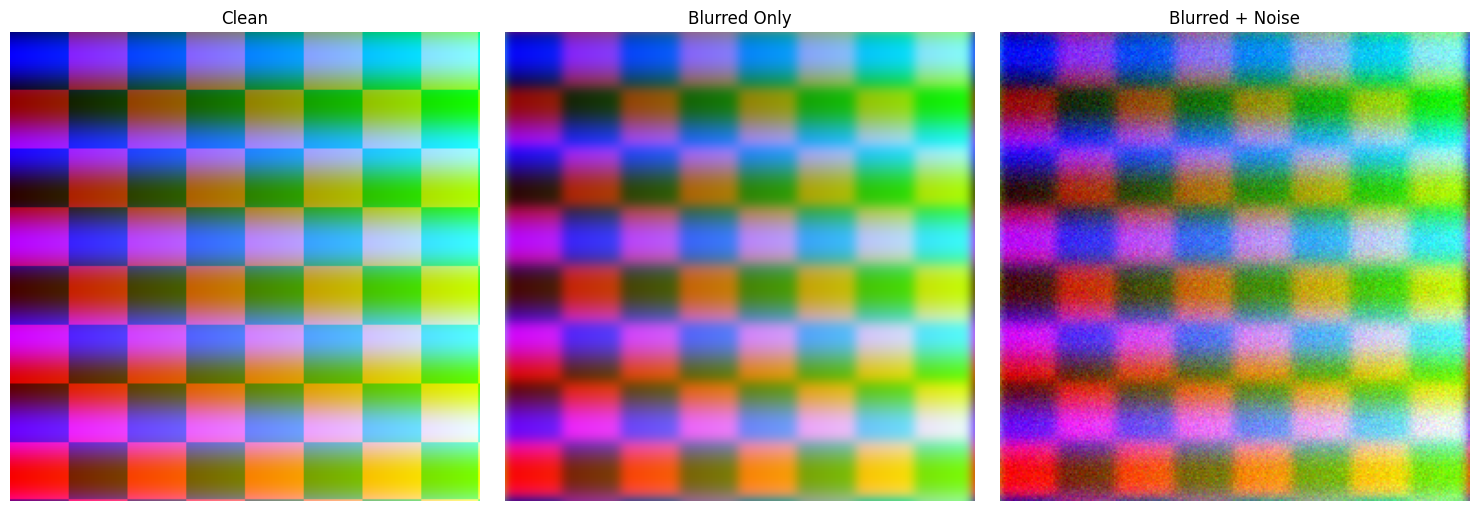

In [44]:
# Degrade image with blur and noise
result = degrade_image(clean, blur_sigma=3.0, noise_sigma=0.05, seed=42)

print(f"Blur kernel shape: {result['kernel'].shape}")
print(f"Noise sigma: {result['params']['noise_sigma']}")

show_images(
    [clean, result['blurred'], result['degraded']],
    ['Clean', 'Blurred Only', 'Blurred + Noise']
)

## 3. Frequency Response Analysis

**Key Insight:** The blur kernel's frequency response |H(f)| shows which frequencies are attenuated. 
Where |H(f)| ≈ 0, information is destroyed - these are the "null" frequencies where we hypothesize diffusion models will be miscalibrated.

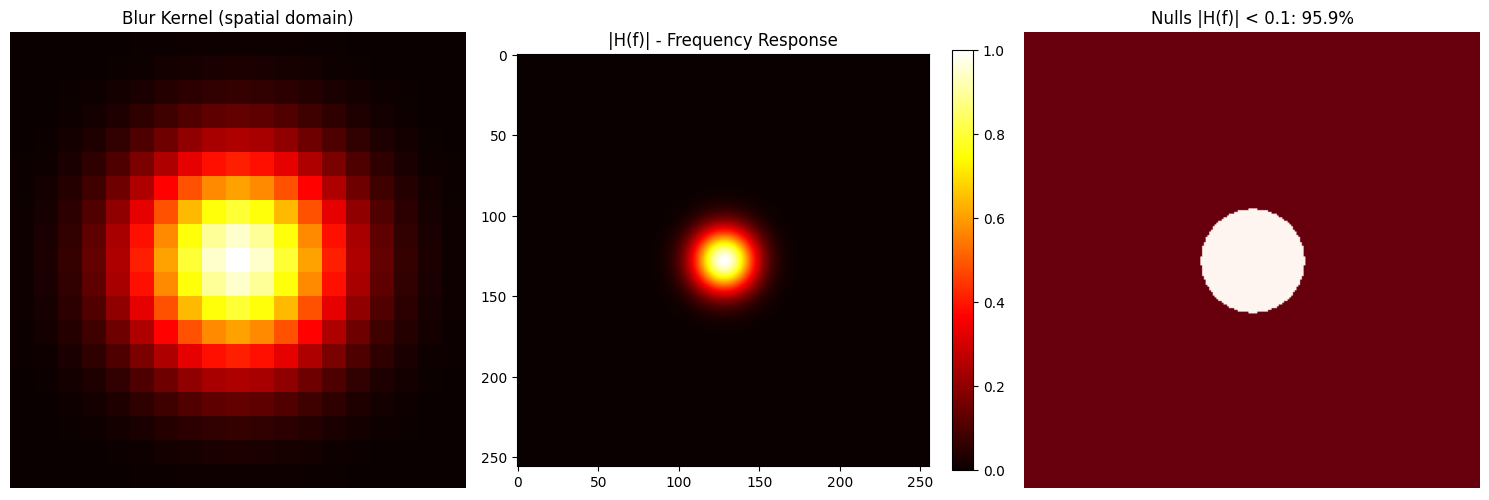

KEY: 95.9% of frequencies have |H(f)| < 0.1
Hypothesis: Diffusion will be miscalibrated at these null frequencies!


In [45]:
# Analyze frequency response of the blur kernel
kernel = result['kernel']
H_mag = get_kernel_frequency_response(kernel, (256, 256))
H_centered = torch.fft.fftshift(H_mag)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Spatial kernel
axes[0].imshow(kernel.numpy(), cmap='hot')
axes[0].set_title('Blur Kernel (spatial domain)')
axes[0].axis('off')

# Frequency response magnitude
im = axes[1].imshow(H_centered.numpy(), cmap='hot', vmin=0, vmax=1)
axes[1].set_title('|H(f)| - Frequency Response')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Null frequencies (where info is lost)
nulls = (H_centered < 0.1).float()
axes[2].imshow(nulls.numpy(), cmap='Reds')
axes[2].set_title(f'Nulls |H(f)| < 0.1: {nulls.mean()*100:.1f}%')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"KEY: {nulls.mean()*100:.1f}% of frequencies have |H(f)| < 0.1")
print("Hypothesis: Diffusion will be miscalibrated at these null frequencies!")

## 4. Wiener Filter Restoration

The Wiener filter provides the optimal linear estimator under Gaussian assumptions. Critically, it also gives us **closed-form posterior variance** - our calibration reference.

PSNR: 11.88 dB


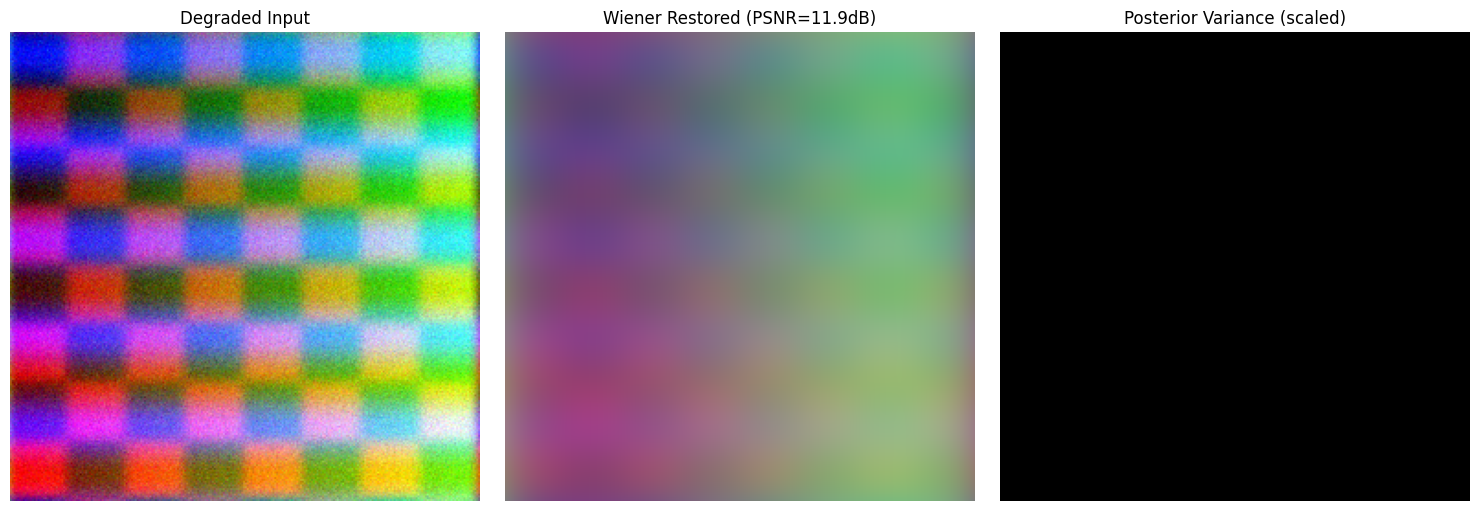

In [46]:
# Wiener filter restoration with uncertainty quantification
wf = WienerFilter(result['kernel'], noise_sigma=0.05, image_shape=(256, 256))

# Restore and get variance
restored, var_spatial, var_freq = wf.restore(result['degraded'])

# Compute quality metric
psnr = compute_psnr(restored, clean)
print(f"PSNR: {psnr:.2f} dB")

# Visualize results
show_images(
    [result['degraded'], restored, var_spatial.unsqueeze(0).repeat(3, 1, 1) * 10],
    ['Degraded Input', f'Wiener Restored (PSNR={psnr:.1f}dB)', 'Posterior Variance (scaled)']
)

## 5. Posterior Sampling

Sample from the Gaussian posterior to visualize uncertainty. The diversity in samples shows where the model is uncertain.

Clean image variance: 0.0974

Posterior variance diagnostics:
  var_freq min:  1.95e-07
  var_freq max:  2.44e-03
  var_freq mean: 2.76e-06

Samples shape: torch.Size([20, 3, 256, 256])
Sample 0 vs Sample 1:
  max diff:  0.004372
  mean diff: 0.000153


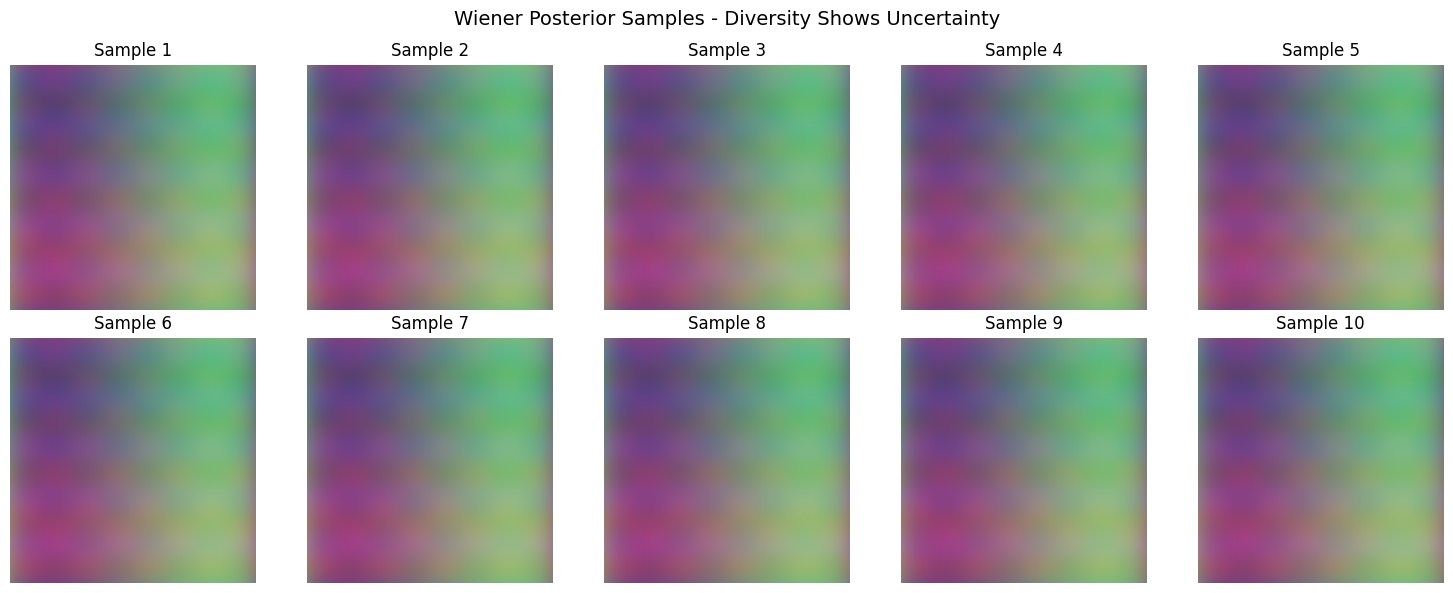


Sample mean PSNR: 11.86 dB
Mean pixel std: 0.0001


In [47]:
# Reload wiener module to get the fix
import importlib
import wiener
importlib.reload(wiener)
from wiener import WienerFilter

# Recreate filter with updated code - use signal_power based on image variance
# For images in [0,1], variance ~0.08 is typical
signal_var = clean.var().item()
print(f"Clean image variance: {signal_var:.4f}")

wf = WienerFilter(result['kernel'], noise_sigma=0.05, image_shape=(256, 256), signal_power=signal_var)

# Debug: Check variance values
print("\nPosterior variance diagnostics:")
print(f"  var_freq min:  {wf.posterior_var_freq.min():.2e}")
print(f"  var_freq max:  {wf.posterior_var_freq.max():.2e}")
print(f"  var_freq mean: {wf.posterior_var_freq.mean():.2e}")

# Sample from Wiener posterior
samples = wf.sample_posterior(result['degraded'], n_samples=20)
print(f"\nSamples shape: {samples.shape}")

# Check sample diversity
diff = (samples[0] - samples[1]).abs()
print(f"Sample 0 vs Sample 1:")
print(f"  max diff:  {diff.max():.6f}")
print(f"  mean diff: {diff.mean():.6f}")

# Display sample diversity
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(samples[i].permute(1, 2, 0).clip(0, 1).numpy())
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.suptitle('Wiener Posterior Samples - Diversity Shows Uncertainty', fontsize=14)
plt.tight_layout()
plt.show()

# Compute sample statistics
sample_mean = samples.mean(dim=0)
sample_std = samples.std(dim=0)
print(f"\nSample mean PSNR: {compute_psnr(sample_mean, clean):.2f} dB")
print(f"Mean pixel std: {sample_std.mean():.4f}")

## 6. Variance vs Frequency Response

**Core CURE hypothesis:** Posterior variance should be HIGH where |H(f)| is LOW (information destroyed by blur).

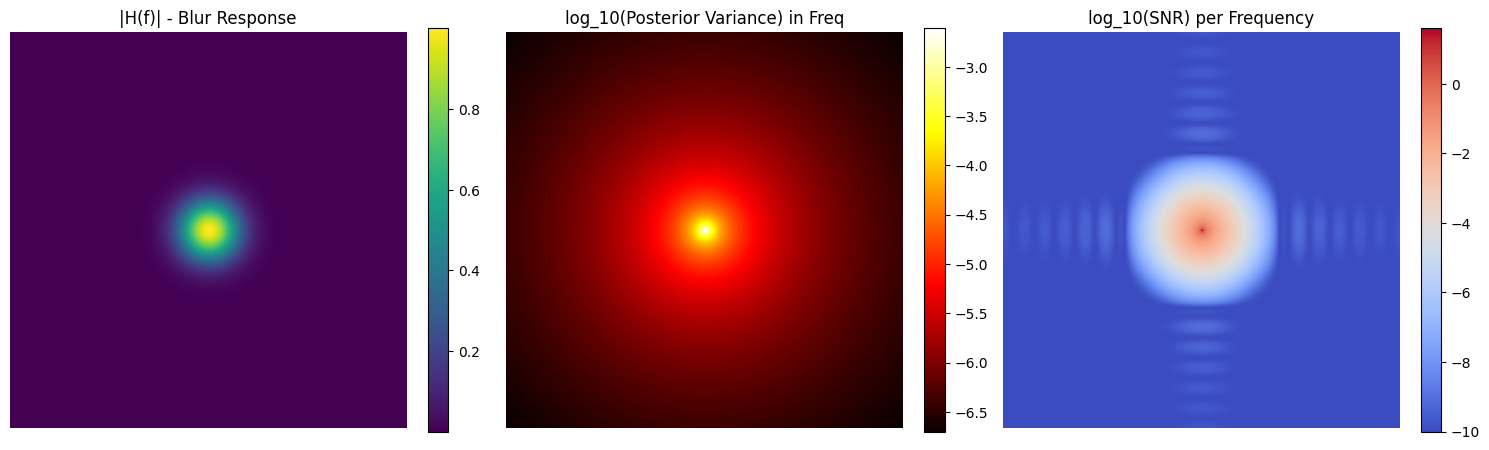

Notice: High variance (bright) corresponds to low |H(f)| (dark in first plot)
This is expected - uncertainty is highest where blur destroys information!


In [48]:
# Visualize relationship between |H(f)| and variance
var_freq_centered = torch.fft.fftshift(var_freq)
snr = wf.get_snr_per_frequency()
snr_centered = torch.fft.fftshift(snr)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Frequency response
im0 = axes[0].imshow(H_centered.numpy(), cmap='viridis')
axes[0].set_title('|H(f)| - Blur Response')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Posterior variance in frequency domain  
im1 = axes[1].imshow(torch.log10(var_freq_centered + 1e-10).numpy(), cmap='hot')
axes[1].set_title('log_10(Posterior Variance) in Freq')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# SNR per frequency
im2 = axes[2].imshow(torch.log10(snr_centered + 1e-10).numpy(), cmap='coolwarm')
axes[2].set_title('log_10(SNR) per Frequency')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Notice: High variance (bright) corresponds to low |H(f)| (dark in first plot)")
print("This is expected - uncertainty is highest where blur destroys information!")

## Summary & Next Steps

**What we've established:**
1. Blur destroys high-frequency information (|H(f)| -> 0)
2. Wiener filter provides provably correct posterior variance
3. Variance is HIGH where |H(f)| is LOW (as expected)

**Next steps for CURE:**
1. Compare Wiener calibration vs DPS (diffusion) calibration
2. Compute frequency-resolved ECE to quantify miscalibration
3. Train recalibrator to correct DPS uncertainty using Wiener as reference